# Time Series Data Visualization and Analysis Notebook

This Jupyter notebook is designed to offer comprehensive tools for time series analysis, including data loading, preprocessing, visualization, analysis, and forecasting. Below is the layout of the notebook with six cells, each performing a specific task.



In [2]:
## Cell 1: Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures


#### Loading Data from CSV 

In [17]:
# Replace 'your_data.csv' with your actual file path
ecg = pd.read_csv('./data/dummy_ecg_data.csv', parse_dates=True, index_col='Date')
ecg.head()

,ECG
Date,
2021-01-01 00:00:00,1.764052
2021-01-01 00:00:01,0.400157
2021-01-01 00:00:02,0.978738
2021-01-01 00:00:03,2.240893
2021-01-01 00:00:04,1.867558


## Cell 3: Data Preprocessing

In this cell, we will perform several preprocessing steps to prepare the ECG data for analysis. Preprocessing steps often include handling missing values, normalizing or standardizing data, and feature engineering if necessary. Given that ECG data typically requires precise measurements, we'll check for any anomalies or outliers that might skew our analysis.

In [22]:
from tqdm.notebook import tqdm

# Initializing the progress bar
with tqdm(total=4, desc="Data Preprocessing Progress") as pbar:
    try:


        # Step 1: Interpolate Missing Values
        # Interpolating missing values in the ECG data to maintain time series continuity
        ecg.interpolate(method='linear', inplace=True)
        pbar.update(1)

        # Drop any remaining missing values after interpolation
        ecg.dropna(inplace=True)
        missing_values_after_interpolation = ecg.isnull().sum()
        print(f"Remaining missing values after interpolation:\n{missing_values_after_interpolation}")

        # Step 2: Data Normalization/Standardization (if necessary)
        ecg['ECG'] = (ecg['ECG'] - ecg['ECG'].mean()) / ecg['ECG'].std()
        pbar.update(1)

        # Step 3: Checking for Outliers
        ecg = ecg.clip(lower=ecg['ECG'].quantile(0.01), upper=ecg['ECG'].quantile(0.99))
        pbar.update(1)

        # Step 4: Creating rolling window features
        # Creating rolling window features
        window_size = 5  # Example window size
        ecg['Rolling_Mean'] = ecg['ECG'].rolling(window=window_size, min_periods=1).mean()

        # For Rolling_Std, handling the NaN values
        ecg['Rolling_Std'] = ecg['ECG'].rolling(window=window_size, min_periods=1).std()
        ecg['Rolling_Std'].fillna(0, inplace=True)  # Replace NaN values with 0 or use .ffill()/.bfill() as needed
    finally:
    # This ensures that the progress bar is closed properly
        pbar.update(1)
        pbar.close()

# Displaying the first few rows of the processed data
ecg.head()




Data Preprocessing Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Remaining missing values after interpolation:
ECG             0
Rolling_Mean    0
Rolling_Std     0
dtype: int64


,ECG,Rolling_Mean,Rolling_Std
Date,,,
2021-01-01 00:00:01,0.458404,0.458404,0.000000
2021-01-01 00:00:02,1.052931,0.755668,0.420394
2021-01-01 00:00:03,2.349872,1.287069,0.967227
2021-01-01 00:00:04,1.966247,1.456864,0.859655
2021-01-01 00:00:05,-0.956993,0.974092,1.311334


#### Data Visualization

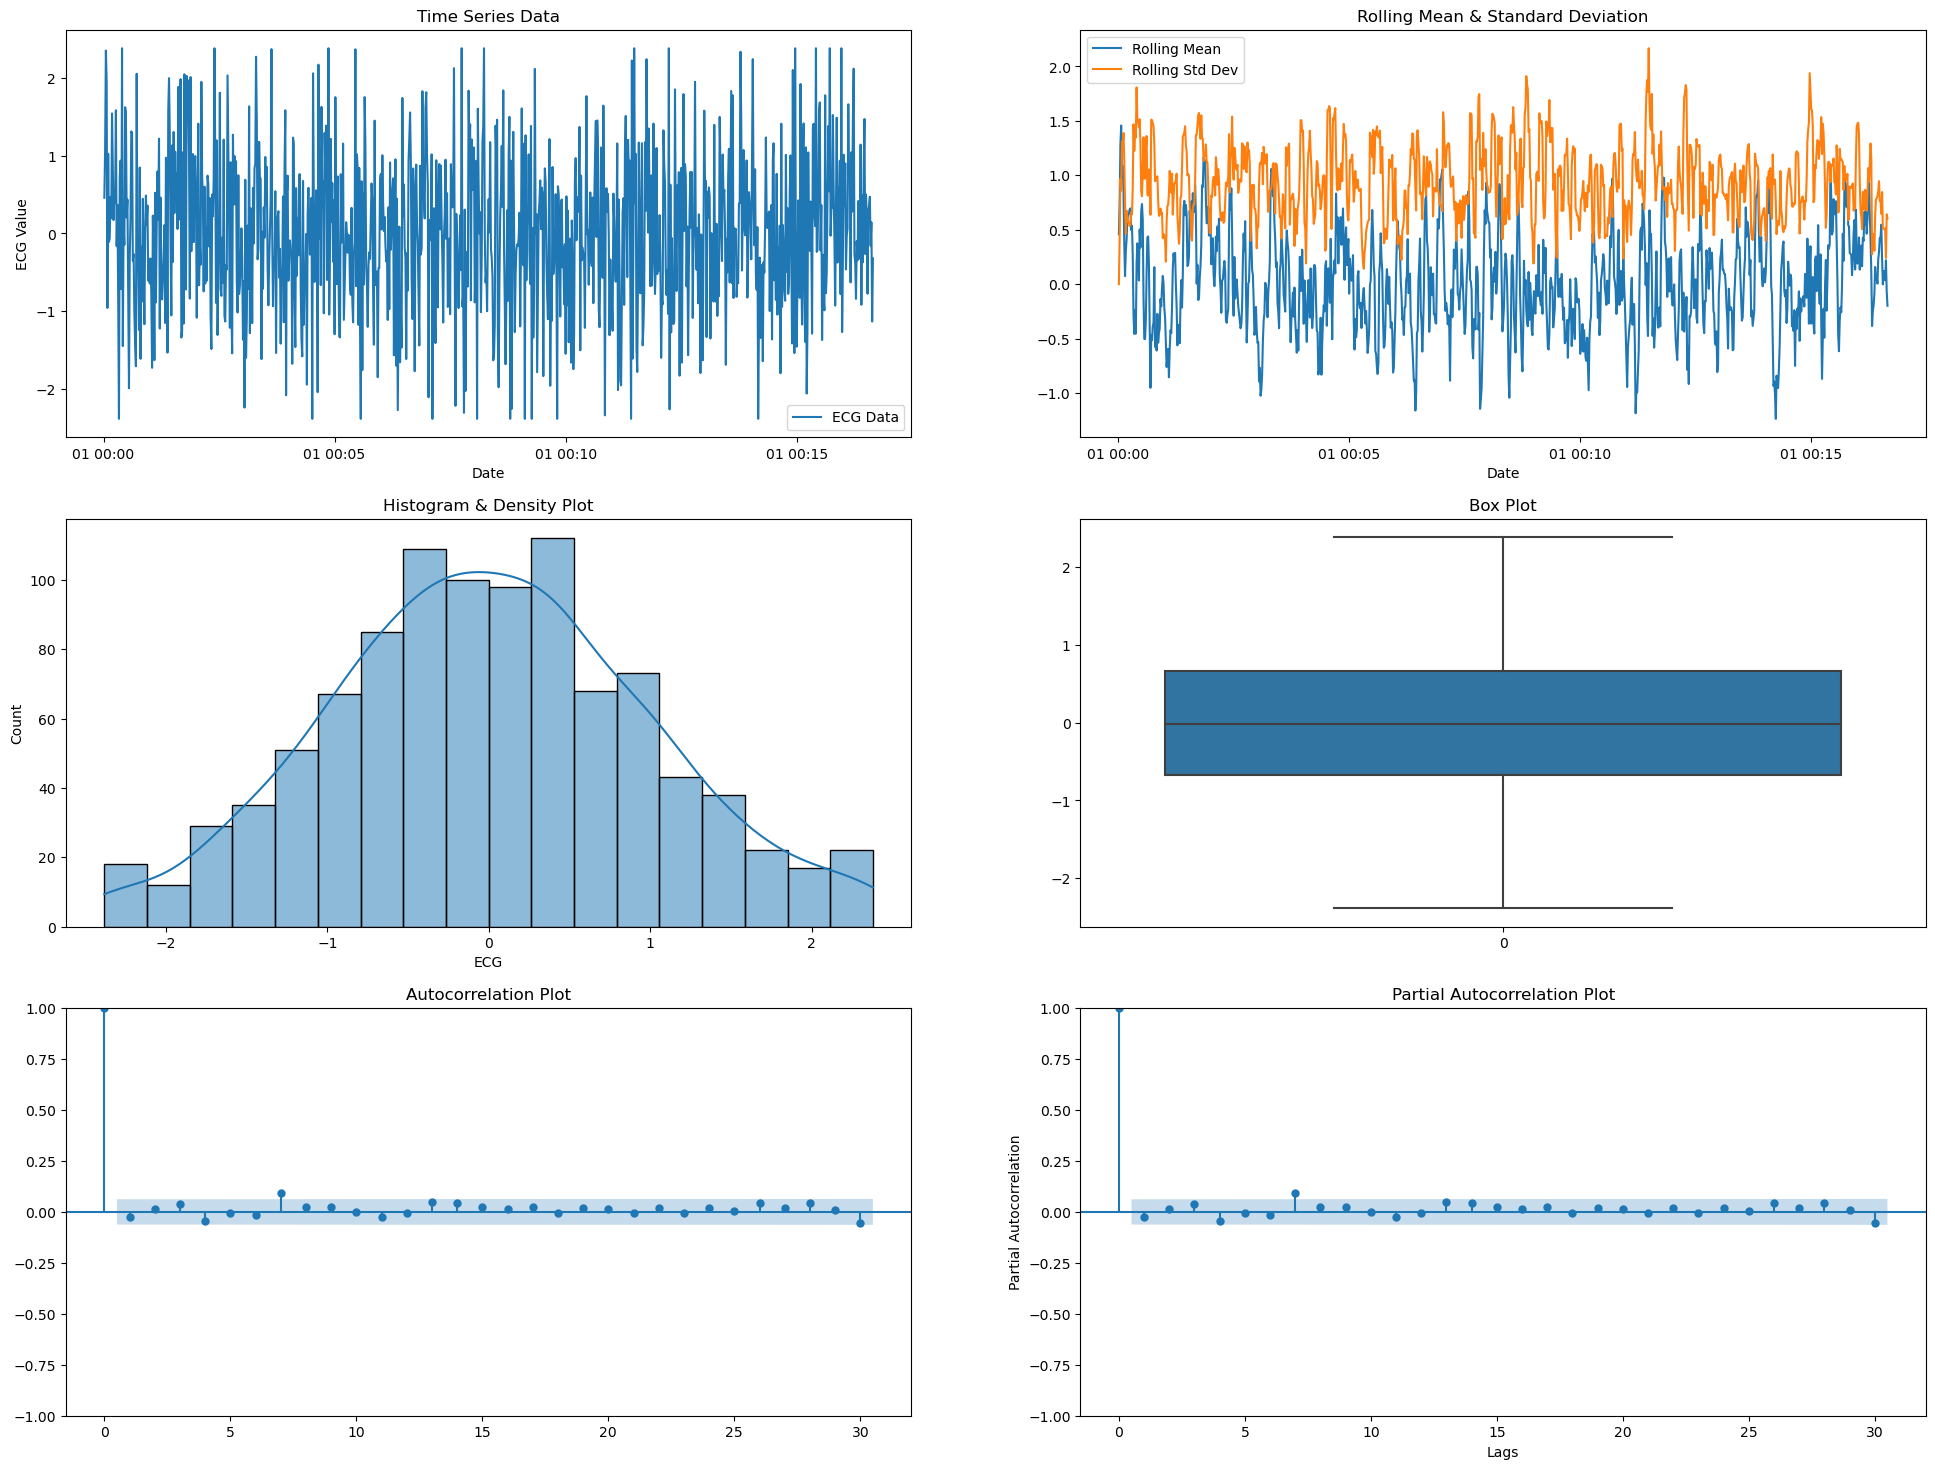

<Figure size 640x480 with 0 Axes>

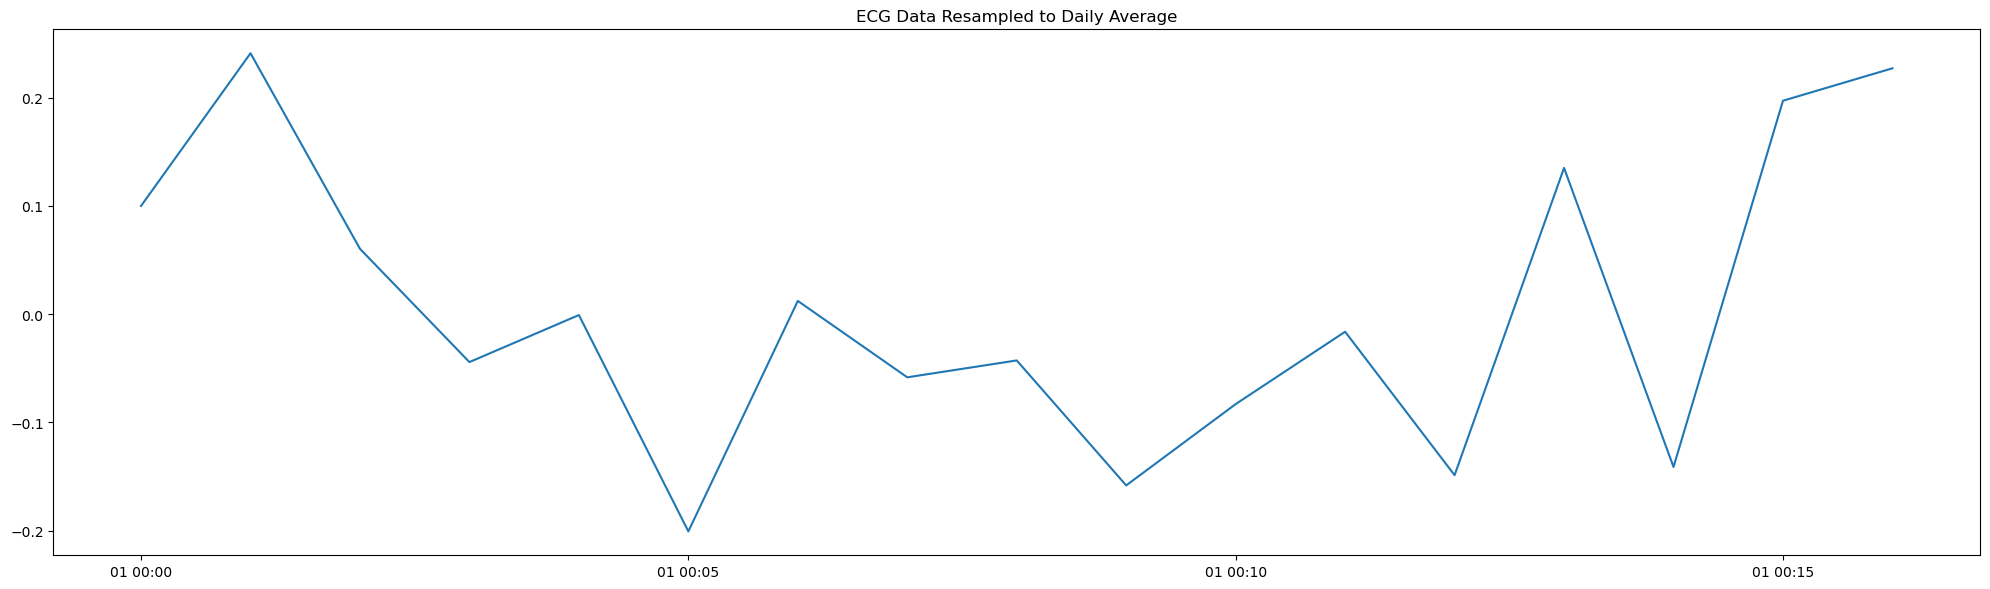

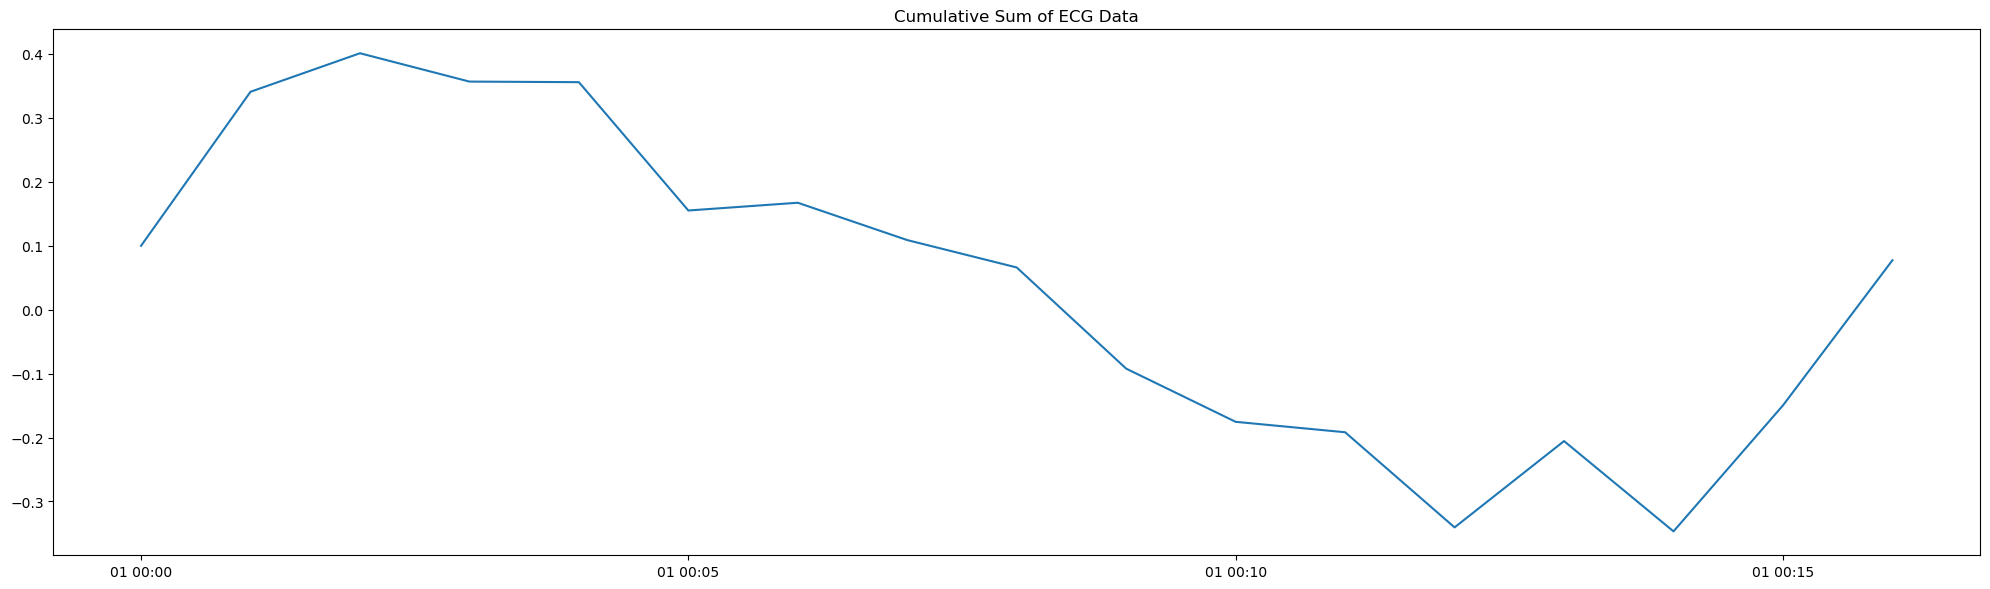

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose


# Parameters for customization
resample_freq = 'T'  # 'T' for minutes
decompose_model = 'additive'  # Can be 'additive' or 'multiplicative'
decompose_period = 5  # Adjusted based on the number of observations

# Resample the data to a regular time interval
ecg_resampled = ecg['ECG'].resample(resample_freq).mean()

# Explicitly setting the frequency of the resampled DataFrame
ecg_resampled = ecg_resampled.asfreq(resample_freq)

# Apply seasonal_decompose to the resampled data
decomposition = seasonal_decompose(ecg_resampled.dropna(), model=decompose_model, period=decompose_period)


# Create the dashboard
plt.figure(figsize=(24, 18))

# Line Plot for Time Series Data
plt.subplot(3, 2, 1)  # 3 rows, 2 columns, 1st subplot
plt.plot(ecg['ECG'], label='ECG Data')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('ECG Value')
plt.legend()

# Rolling Mean and Standard Deviation Plots
plt.subplot(3, 2, 2)  # 3 rows, 2 columns, 2nd subplot
plt.plot(ecg['Rolling_Mean'], label='Rolling Mean')
plt.plot(ecg['Rolling_Std'], label='Rolling Std Dev')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.legend()

# Histogram and Density Plot
plt.subplot(3, 2, 3)  # 3rd subplot
sns.histplot(ecg['ECG'], kde=True)
plt.title('Histogram & Density Plot')

# Box Plot
plt.subplot(3, 2, 4)  # 4th subplot
sns.boxplot(data=ecg['ECG'])
plt.title('Box Plot')

# Correlogram or Autocorrelation Plot
plt.subplot(3, 2, 5)  # 5th subplot
plot_acf(ecg['ECG'], ax=plt.gca())
plt.title('Autocorrelation Plot')

# Plot 6 
plt.subplot(3, 2, 6)  # 5th subplot
plot_acf(ecg['ECG'], ax=plt.gca())
plt.title('Partial Autocorrelation Plot')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

# Adjust the layout
plt.tight_layout()
plt.show()

# Plot 8: Resampled Data Plot
plt.figure(figsize=(20, 6))  # Adjust figure size as needed
plt.plot(ecg_resampled)
plt.title('ECG Data Resampled to Daily Average')
plt.tight_layout()
plt.show()

# Plot 9: Cumulative Sum Plot
plt.figure(figsize=(20, 6))  # Adjust figure size as needed
plt.plot(ecg_resampled.cumsum())
plt.title('Cumulative Sum of ECG Data')
plt.tight_layout()
plt.show()



#### Time Series Decomposition

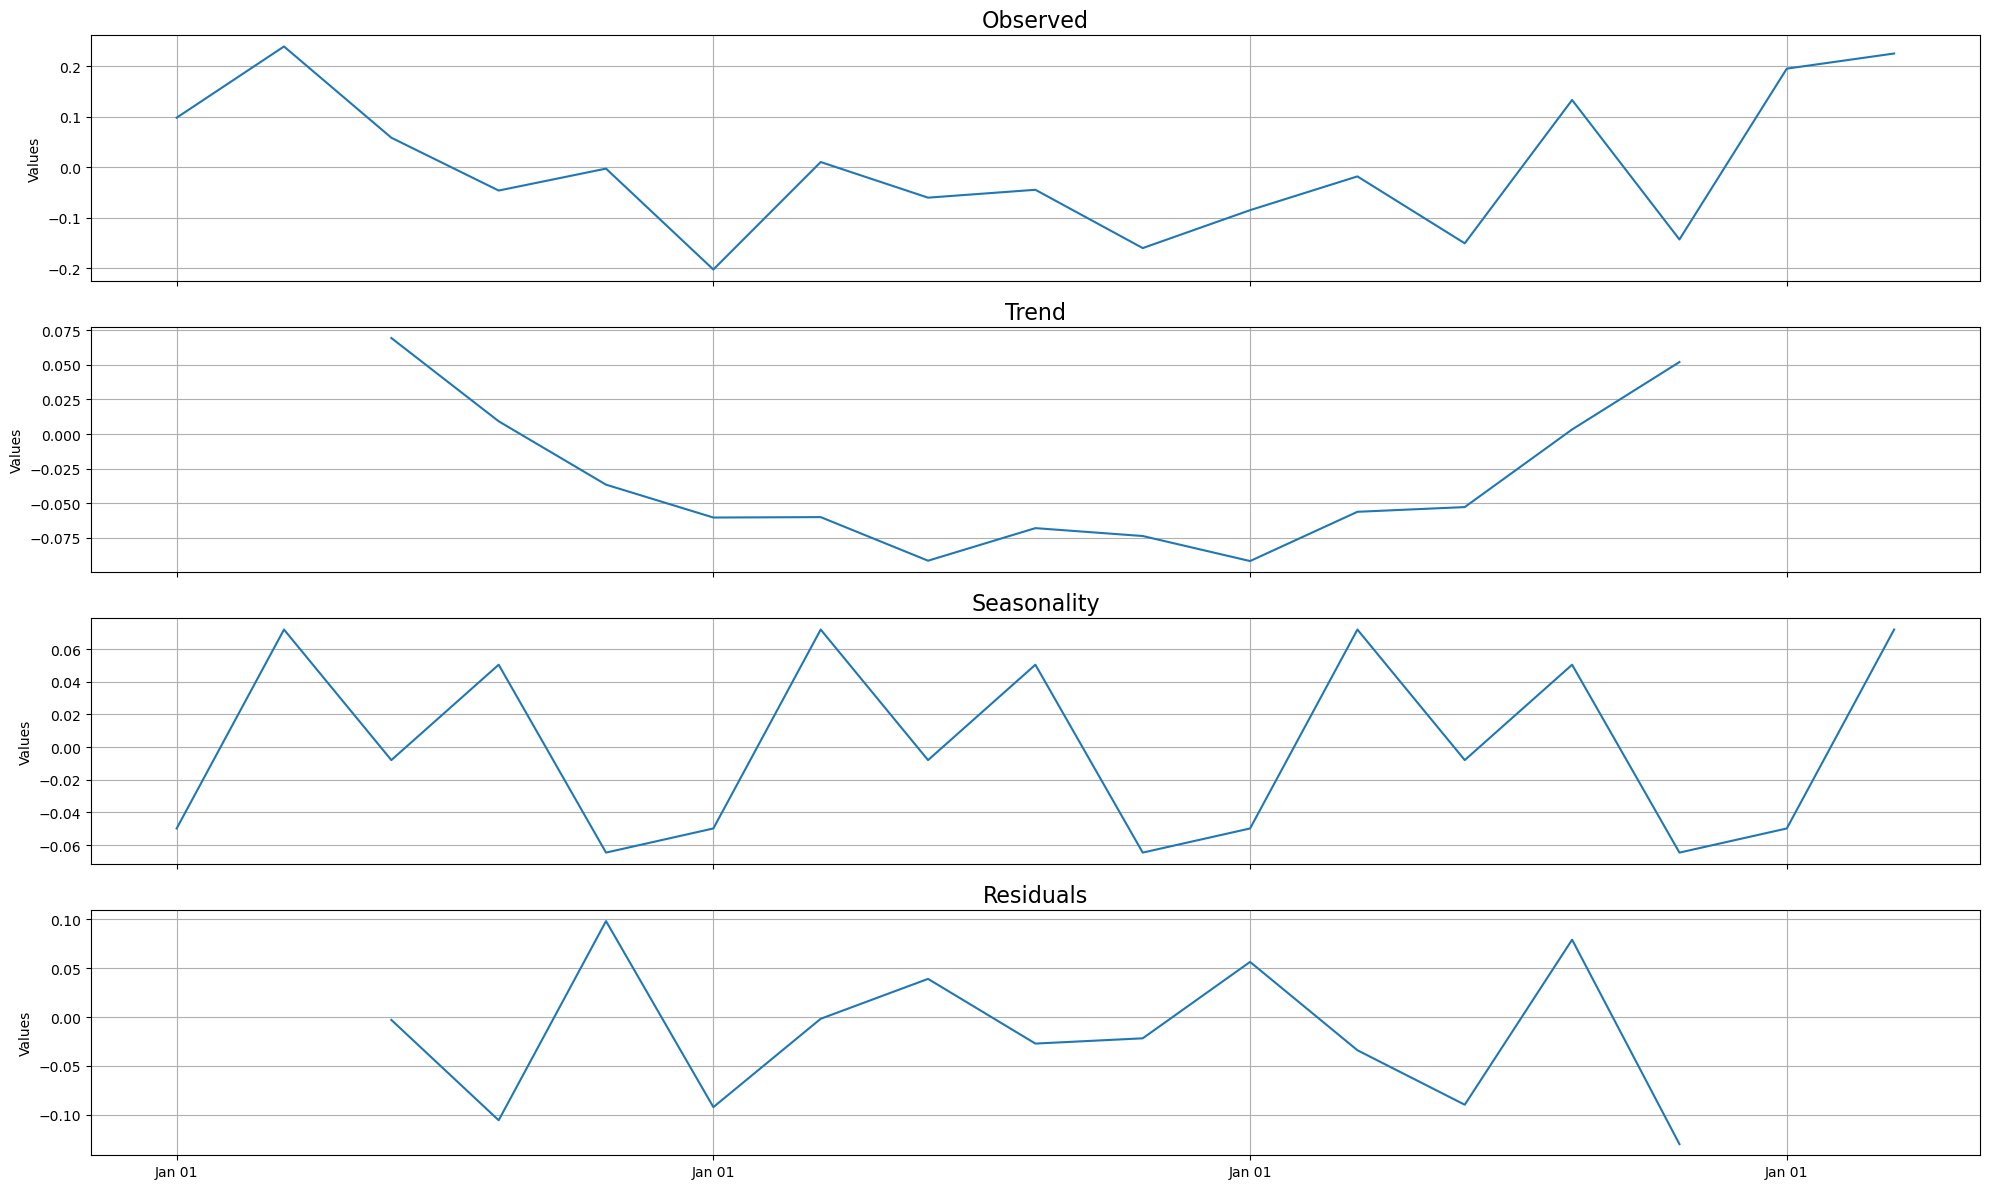

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# Perform the seasonal decomposition
decomposition = seasonal_decompose(ecg_resampled.dropna(), model='additive', period=decompose_period)

# Define the figure and axes
fig, axes = plt.subplots(4, 1, figsize=(20, 12), sharex=True)

# Observed
axes[0].plot(decomposition.observed)
axes[0].set_title('Observed', fontsize=16)
axes[0].set_ylabel('Values')
axes[0].grid(True)

# Trend
axes[1].plot(decomposition.trend)
axes[1].set_title('Trend', fontsize=16)
axes[1].set_ylabel('Values')
axes[1].grid(True)

# Seasonal
axes[2].plot(decomposition.seasonal)
axes[2].set_title('Seasonality', fontsize=16)
axes[2].set_ylabel('Values')
axes[2].grid(True)

# Residual
axes[3].plot(decomposition.resid)
axes[3].set_title('Residuals', fontsize=16)
axes[3].set_ylabel('Values')
axes[3].grid(True)

# Improve the x-axis date format
axes[3].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.show()

#### Forecasting

In [24]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Preprocessing for LSTM
scaler = MinMaxScaler()
scaled_ecg = scaler.fit_transform(ecg[['ECG']])

# Define sequence length and create the generator for LSTM
sequence_length = 5
generator = TimeseriesGenerator(scaled_ecg, scaled_ecg, length=sequence_length, batch_size=1)



#### Model Setup

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
import plotly as py

# Setup ARIMA model
# Replace order with appropriate parameters based on your time series
arima_order = (5, 1, 0)

# Setup LSTM model
# Specify the architecture as per your requirement
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')


# Holt-Winters Model Setup
# Note: You need to define the seasonal_periods based on your data's seasonality
seasonal_periods = 7  # Example: 7 for weekly seasonality in daily data

holt_winters_model = ExponentialSmoothing(
    ecg['ECG'], 
    seasonal_periods=seasonal_periods, 
    trend='add', 
    seasonal='add', 
    damped_trend=True, 
    use_boxcox=False, 
    initialization_method='estimated'
)



/home/min0/anaconda3/envs/AIFlow_Prophet/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)


#### Fitting and Forecasting

In [31]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from tensorflow.keras.callbacks import Callback
from tqdm.notebook import tqdm

class TQDMNotebookCallback(Callback):
    def __init__(self, tqdm_instance):
        self.tqdm_instance = tqdm_instance

    def on_epoch_end(self, epoch, logs=None):
        self.tqdm_instance.update(1)


# Assuming other necessary imports like ARIMA, LSTM model, etc., are already done

# Fit and Forecast ARIMA
with tqdm(total=1, desc="Fitting ARIMA Model") as pbar:
    arima_model = ARIMA(ecg['ECG'], order=arima_order)
    arima_result = arima_model.fit()
    arima_forecast = arima_result.get_forecast(steps=10).predicted_mean
    pbar.update(1)  # Update progress after ARIMA model fitting

# Fit and Forecast LSTM
with tqdm(total=20, desc="Fitting LSTM Model") as pbar:
    lstm_model.fit(generator, epochs=20, verbose=0, callbacks=[TQDMNotebookCallback(pbar)])
    pbar.update(20)  # This line might be redundant as the callback updates the bar


# Forecasting with LSTM
forecast_steps = 10
last_sequence = scaled_ecg[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))
lstm_forecast = []

with tqdm(total=forecast_steps, desc="Forecasting with LSTM") as pbar:
    for _ in range(forecast_steps):
        next_step = lstm_model.predict(last_sequence)
        lstm_forecast.append(next_step[0, 0])
        next_step_reshaped = next_step.reshape(1, 1, 1)
        last_sequence = np.append(last_sequence[:, 1:, :], next_step_reshaped, axis=1)
        pbar.update(1)  # Update progress after each forecast step

try:
    lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))
    forecast_index = pd.date_range(start=ecg.index[-1], periods=forecast_steps + 1, freq='S')[1:]
    lstm_forecast = pd.Series(data=lstm_forecast.flatten(), index=forecast_index)

    # Fit and Forecast with Holt-Winters Model
    with tqdm(total=1, desc="Fitting Holt-Winters Model") as pbar:
        hw_model_fit = holt_winters_model.fit(optimized=True)
        hw_forecast = hw_model_fit.forecast(steps=10)
        pbar.update(1)  # Update progress after Holt-Winters model fitting

except ValueError as e:
    print(f"An error occurred: {e}")




Fitting ARIMA Model:   0%|          | 0/1 [00:00<?, ?it/s]

/home/min0/anaconda3/envs/AIFlow_Prophet/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)
/home/min0/anaconda3/envs/AIFlow_Prophet/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)
/home/min0/anaconda3/envs/AIFlow_Prophet/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)


Fitting LSTM Model:   0%|          | 0/20 [00:00<?, ?it/s]

Forecasting with LSTM:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


Fitting Holt-Winters Model:   0%|          | 0/1 [00:00<?, ?it/s]

#### Plotting Forecasts

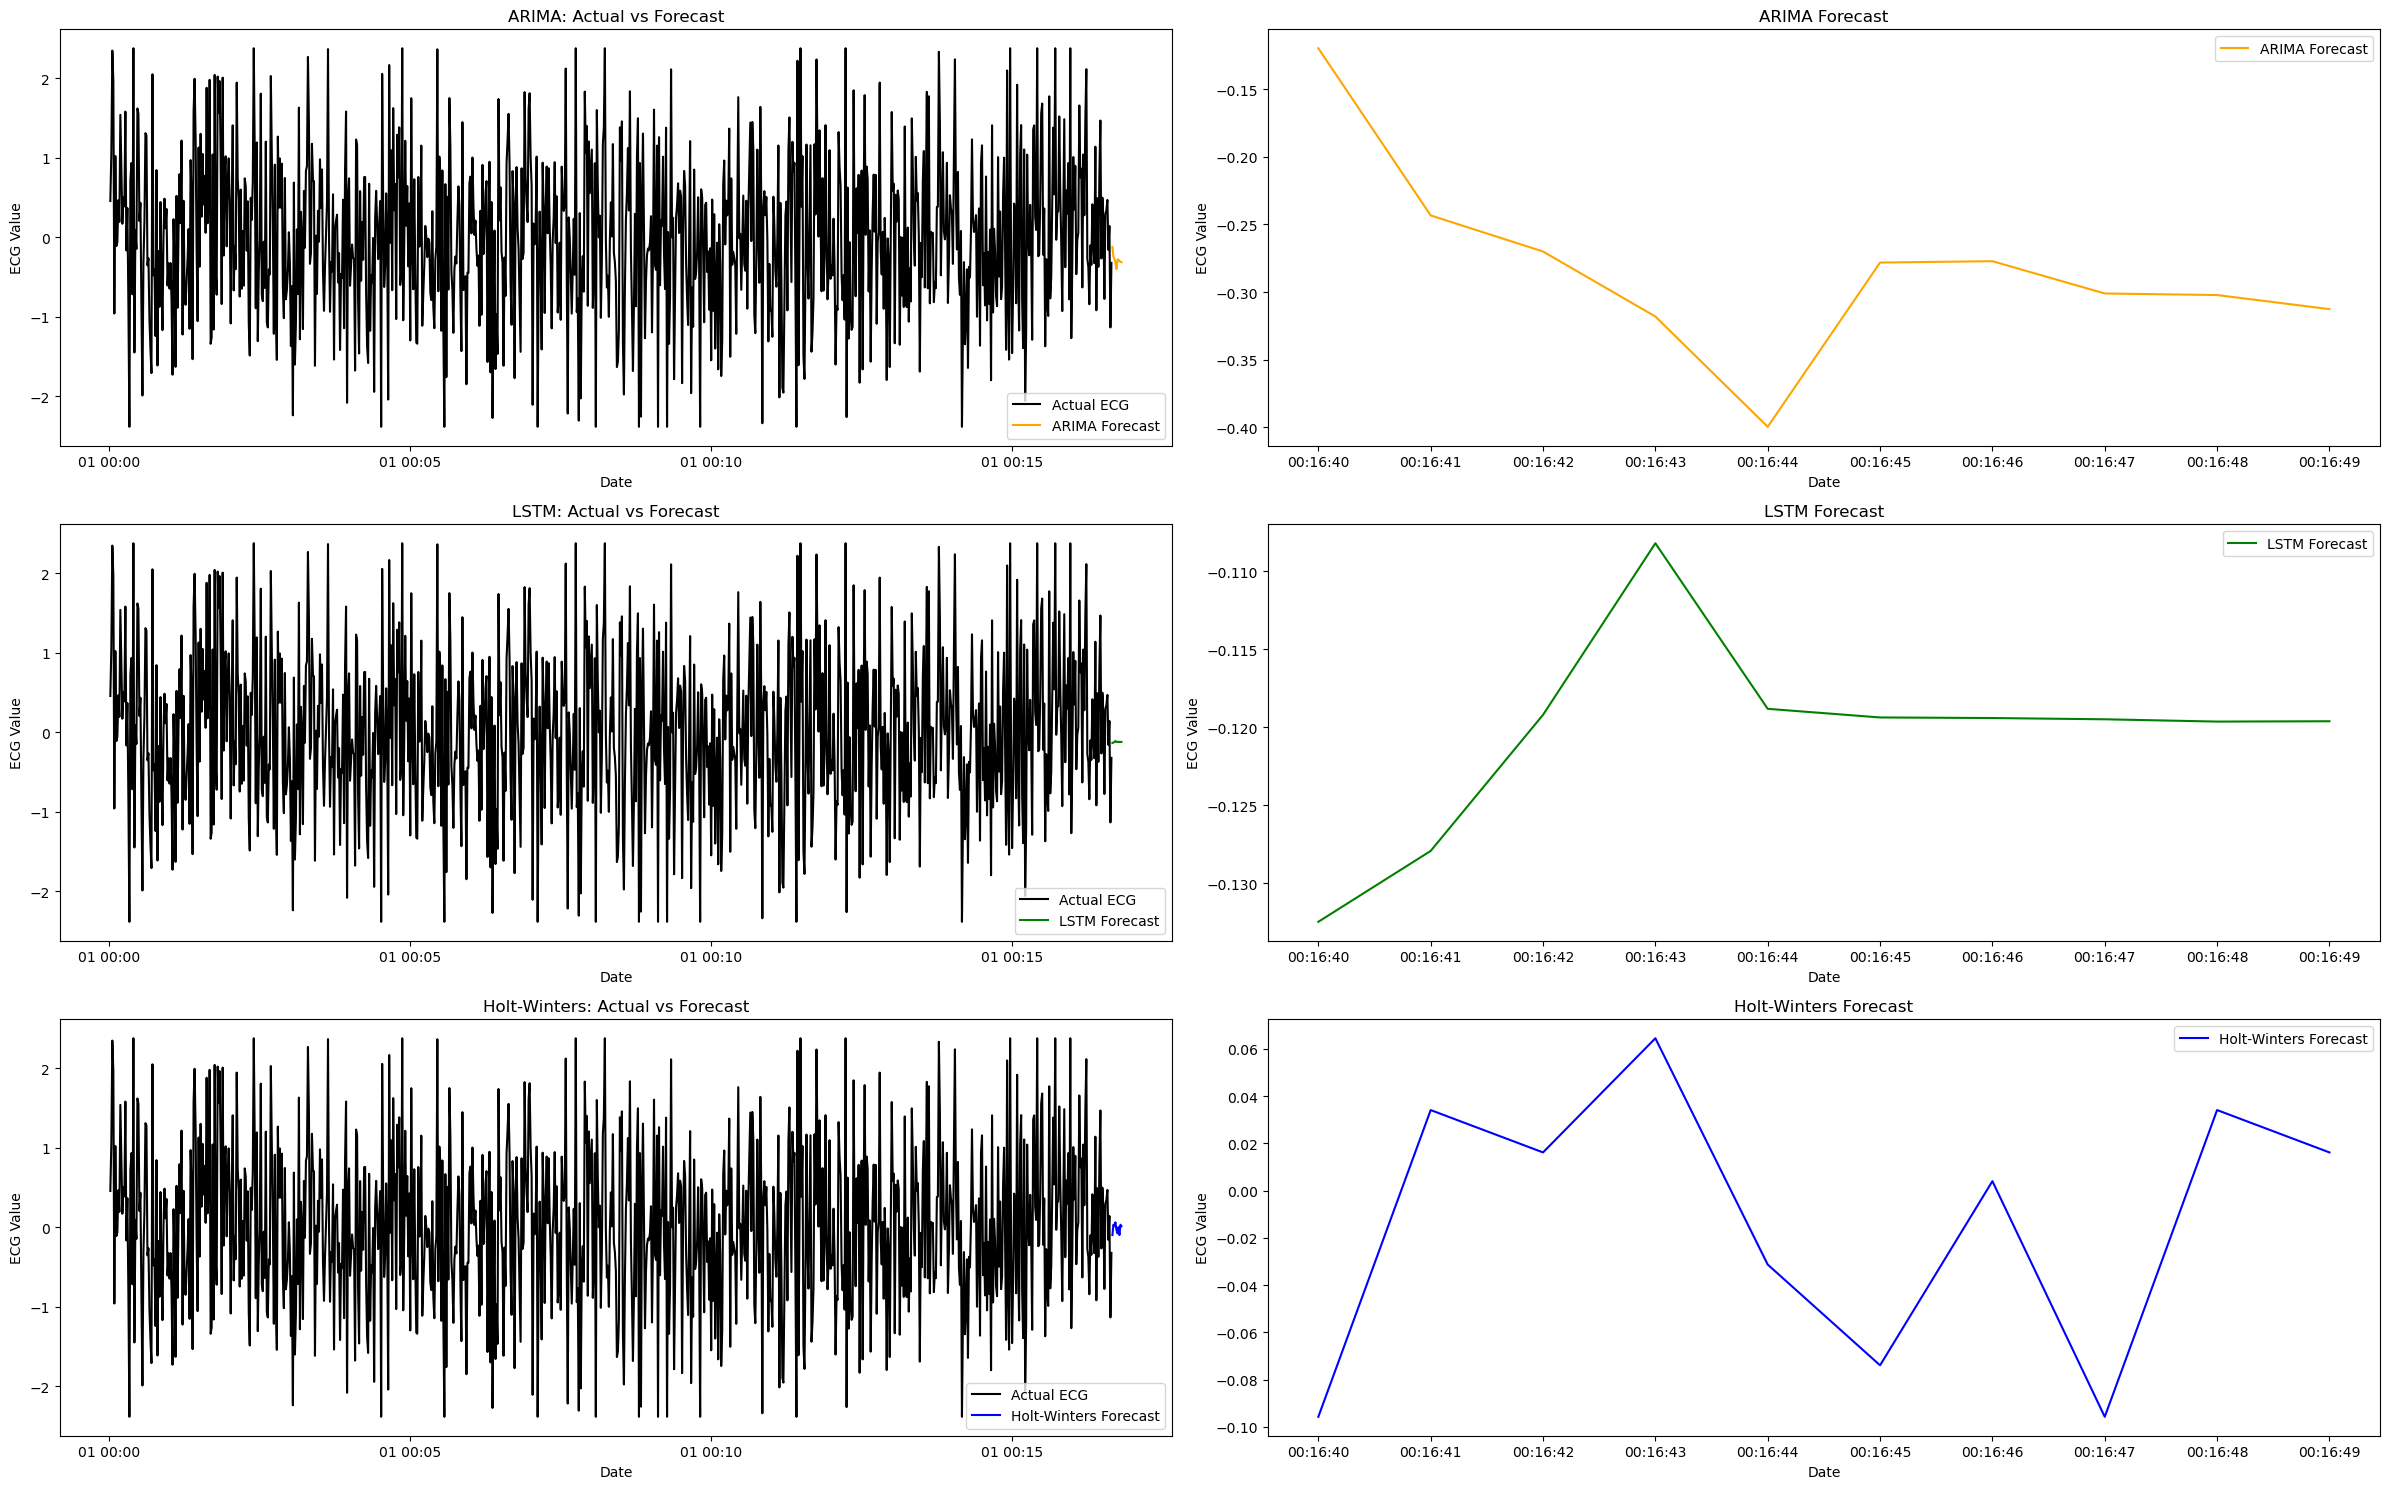

In [34]:
import matplotlib.pyplot as plt

# Assuming you have forecasts from ARIMA (arima_forecast), LSTM (lstm_forecast), 
# and Holt-Winters (hw_forecast), and the actual data (ecg)

# Define the number of rows and columns for the subplot grid
n_rows, n_cols = 3, 2
plt.figure(figsize=(24, 15))

# ARIMA Plots
plt.subplot(n_rows, n_cols, 1)
plt.plot(ecg['ECG'], label='Actual ECG', color='black')
plt.plot(arima_forecast, label='ARIMA Forecast', color='orange')
plt.title('ARIMA: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('ECG Value')
plt.legend()

plt.subplot(n_rows, n_cols, 2)
plt.plot(arima_forecast, label='ARIMA Forecast', color='orange')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('ECG Value')
plt.legend()

# LSTM Plots
plt.subplot(n_rows, n_cols, 3)
plt.plot(ecg['ECG'], label='Actual ECG', color='black')
plt.plot(lstm_forecast, label='LSTM Forecast', color='green')
plt.title('LSTM: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('ECG Value')
plt.legend()

plt.subplot(n_rows, n_cols, 4)
plt.plot(lstm_forecast, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('ECG Value')
plt.legend()

# Holt-Winters Plots
plt.subplot(n_rows, n_cols, 5)
plt.plot(ecg['ECG'], label='Actual ECG', color='black')
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='blue')
plt.title('Holt-Winters: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('ECG Value')
plt.legend()

plt.subplot(n_rows, n_cols, 6)
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='blue')
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('ECG Value')
plt.legend()

# Adjust layout for better display
plt.tight_layout()
plt.show()